# Creando imagenes con modelos difusos pre-entrenados

### Flujo del notebook 

1. Clonar los githubs donde estan los modelos pre-entrenados y las clases de entrenamiento
2. Descargar el modelo de difusión pre-entreanado
3. Configurar el acceso a los datos de entrenamiento 
4. Entrenar el modelo pre-entrenado con nuestras imagenes
5. Pruebas del modelo 

### Flujo del fine-tunning/re-training del modelo de difusión

1. Preparar tu conjunto de datos
* Recopilación de imágenes: reúne un conjunto de imágenes de las que quieres que aprenda el modelo. Este conjunto de datos debe ser relevante para el tipo de imágenes que quieres que genere el modelo.
* Preprocesamiento de imágenes: asegúrate de que tus imágenes estén preprocesadas adecuadamente (por ejemplo, redimensionadas, normalizadas) para que coincidan con el formato esperado por el modelo.
2. Proceso de fine-tunning

* Carga del modelo preentrenado: comienza con el modelo de difusión preentrenado.
* Adaptación a tu conjunto de datos: ajusta el modelo en tu conjunto de datos. Esto implica continuar el proceso de entrenamiento con tus datos, ajustando los pesos del modelo para que se ajuste mejor a tus imágenes específicas.
*Detalles del entrenamiento: necesitarás establecer hiperparámetros como la tasa de aprendizaje, el tamaño del lote y la cantidad de épocas de entrenamiento. El fine-tunning generalmente requiere menos épocas en comparación con el entrenamiento desde cero.

* Nota: Entrenamiento desde cero
    * Arquitectura y entrenamiento: si desea entrenar un nuevo modelo desde cero, deberá definir la arquitectura del modelo y entrenarlo utilizando su conjunto de datos desde el principio. Esto requiere más recursos y mayor potencia computacional.
    
### Uso de CLIP como guía en la generación de imágenes
Después de ajustar el modelo de difusión, se utiliza CLIP para guiar el proceso de generación de imágenes.

En este caso, CLIP no se ajusta. En cambio, toma un mensaje de texto (o características de la imagen) y evalúa qué tan bien se alinea la imagen generada con ese mensaje.

El modelo de difusión (que puede haberse ajustado anteriormente) genera imágenes en función de la reducción de ruido a lo largo de muchas iteraciones, mientras que CLIP proporciona retroalimentación en cada paso para garantizar que la imagen generada coincida con el mensaje deseado.

Objetivo: garantizar que la imagen generada se adhiera al mensaje de texto proporcionado mediante el uso de las asociaciones aprendidas de CLIP entre imágenes y texto.

### Motivación

Exploraremos las capacidades creativas de los modelos generativos profundos y profundizaremos cómo podemos utilizar estos modelos, en combinación con modelos generalizados de visión y lenguaje, para crear hermosas obras de arte de varios estilos a partir de indicaciones de texto en lenguaje natural.

Este es el digrama general en el que nuestra lógica estará asentada:

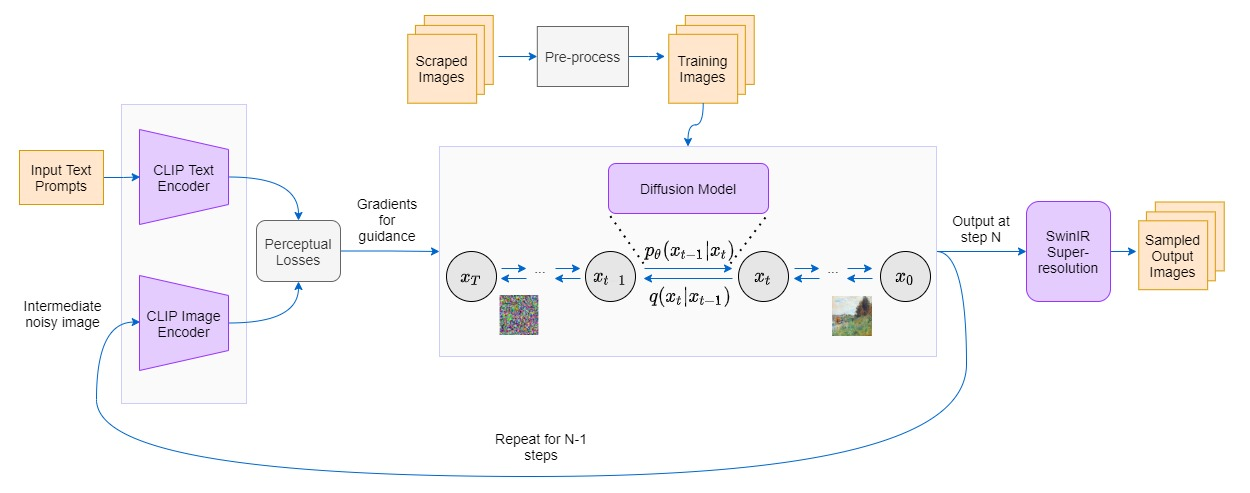

Los modelos de difusión funcionan introduciendo gradualmente ruido en una muestra, comenzando con una imagen sin ruido y luego aprendiendo a revertir ese proceso paso a paso para recuperar los datos originales. Imagine comenzar con ruido aleatorio puro y reducir progresivamente ese ruido con el tiempo para crear una imagen clara y sin ruido.

Inicialmente, los modelos de difusión se entrenaron para predecir la versión ruidosa de una imagen en cada paso, pero investigaciones posteriores (Ho et al.) demostraron que es mejor predecir el ruido en sí mismo en lugar de la imagen ruidosa. Al aprender a estimar el ruido, el modelo puede recuperar de manera más efectiva la imagen subyacente.

Durante el entrenamiento, el modelo toma una muestra de datos reales (como una imagen limpia), agrega una cantidad aleatoria de ruido en un paso de tiempo determinado y luego intenta predecir cuánto ruido se agregó. El objetivo del entrenamiento es minimizar la diferencia entre el ruido real y el ruido predicho por el modelo utilizando una pérdida de error cuadrático medio.

Esta predicción de ruido la realiza una red neuronal, que captura toda la distribución de datos, lo que le permite generar muestras realistas al revertir el proceso de ruido durante la inferencia.

### Principal idea de arquitectura para el proceso de entrenamiento

En este notebook se utilizará (de manera interna) arquitecturas de modelos de difusión y procedimientos de entrenamiento de los artículos Improved Denoising Diffusion Probabilistic Models y Diffusion Models Beat GANs de Dhariwal y Nichol, 2021 (OpenAI), donde los autores han mejorado la verosimilitud logarítmica para maximizar el aprendizaje de todos los modos de distribución de datos, y otras métricas generativas como FID (Fréchet Inception Distance) e IS (Inception Score), para mejorar la fidelidad de la imagen generada. El **modelo** que utilizaremos tiene una arquitectura de red neuronal basada en la columna vertebral de PixelCNN++, que es una **U-Net** basada en una Wide ResNet con normalización de grupo en lugar de normalización de peso, para simplificar la implementación. Estos modelos tienen **dos bloques residuales convolucionales** por nivel de resolución y utilizan **bloques de autoatención de múltiples cabezales** con una resolución de 16x16 y una resolución de 8x8 entre los bloques convolucionales. El tiempo de difusión t se especifica añadiendo la incrustación de posición sinusoidal del **transformador** en cada bloque residual.

Una arquitectura U-Net es un tipo de red neuronal convolucional (CNN) diseñada originalmente para la segmentación de imágenes biomédicas. Tiene una forma distintiva de "U", que se forma por su estructura simétrica de rutas de codificación (reducción de muestreo) y decodificación (sobremuestreo). Las U-Net se utilizan comúnmente para tareas que requieren la localización precisa de características, como la generación y segmentación de imágenes.

Así es como funciona la U-Net:

* Ruta de codificación (reducción de muestreo): el lado izquierdo de la U-Net reduce progresivamente la resolución espacial de la imagen a través de capas convolucionales y operaciones de agrupamiento. Esta ruta extrae características cada vez más abstractas y de alto nivel a medida que se adentra más en la red.

* Cuello de botella: en el punto más profundo de la U, la red tiene la resolución espacial más pequeña pero la representación de características más rica, gracias a sus filtros aprendidos.

* Ruta de decodificación (sobremuestreo): el lado derecho de la U-Net restaura la resolución espacial a través de capas de sobremuestreo. También fusiona (mediante concatenación o adición - skip connections) los mapas de características de las capas correspondientes de la ruta de codificación, lo que permite que la red recupere detalles finos que pueden haberse perdido durante el submuestreo.

En este modelo, la U-Net se construye sobre una estructura principal de Wide ResNet. Una Wide ResNet es un tipo de red residual (ResNet) en la que se aumenta el ancho (número de canales o filtros) de las capas convolucionales. Esto proporciona más capacidad para aprender características enriquecidas mientras se mantiene la dinámica de entrenamiento eficiente de las ResNets estándar, gracias a las conexiones residuales. Estas conexiones residuales pasan por alto algunas capas, lo que ayuda a mitigar el problema del gradiente de desaparición y permite que la red sea más profunda.

En este modelo, cada nivel de resolución de la U-Net tiene dos bloques residuales convolucionales, que ayudan a la red a aprender mejores representaciones y, al mismo tiempo, mantener los beneficios de las conexiones residuales (como el flujo de gradiente eficiente). Estos bloques residuales están diseñados para procesar los datos en diferentes resoluciones espaciales.

En resoluciones inferiores específicas (16×16 y 8×8), el modelo incorpora bloques de autoatención de múltiples cabezales entre las capas convolucionales. Estos bloques de autoatención permiten que la red modele dependencias de largo alcance en los datos, lo que significa que el modelo puede centrarse en las relaciones entre píxeles que están muy separados, lo que es crucial para tareas como la generación o segmentación de imágenes.

Además, el paso de tiempo de difusión t se especifica agregando incrustaciones de posición sinusoidal (de transformadores) en cada bloque residual. Estas incrustaciones codifican el paso de tiempo actual en el proceso de difusión, lo que ayuda al modelo a comprender cuánto ruido se ha agregado y cuánto se debe eliminar. Este condicionamiento de tiempo permite que el modelo prediga el ruido en cualquier paso del proceso de difusión con mayor precisión (Diffusion Time $𝑡$ in diffusion models is associated with the current step in the denoising process. Transformers use positional embeddings to encode this time information, allowing the model to learn and predict based on the current state of diffusion).

Al combinar bloques residuales convolucionales, autoatención en resoluciones clave e incrustaciones de posición, el modelo obtiene capacidades de extracción de características tanto locales como globales, al mismo tiempo que se condiciona al paso de tiempo de difusión para una predicción precisa del ruido.

**Normalización de grupos:**
En lugar de la normalización de peso, este modelo utiliza la normalización de grupos, que normaliza las activaciones dividiéndolas en grupos más pequeños, en lugar de normalizar todo el lote como se hace en la normalización de lotes. La normalización de grupos funciona mejor para tamaños de lotes más pequeños, lo que la hace más flexible, especialmente cuando la memoria de la GPU es limitada o los minilotes son pequeños.

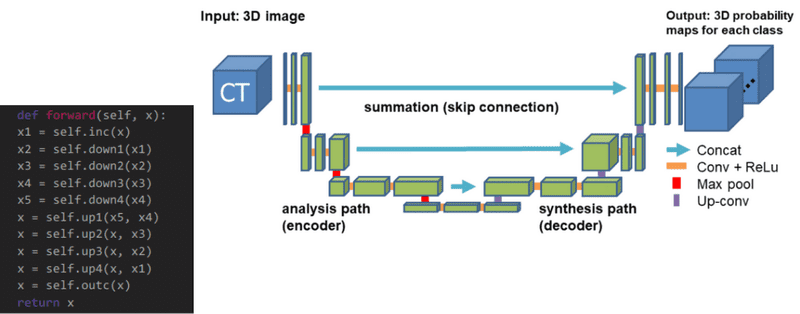!

La función de pérdida en el proceso de entrenamiento es:
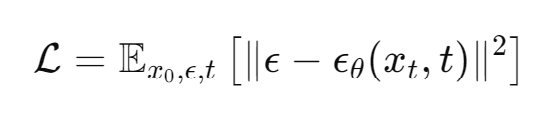
donde:
1. $𝜖$ es el ruido real muestreado de la distribución Gaussiana.
2. $𝜖_{𝜃}(𝑥_{𝑡} ,𝑡)$ es el ruido predicho por el modelo.
3. $𝑥_{𝑡}$ es los datos ruidosos en el paso de tiempo 𝑡, generados durante el proceso hacia adelante.

### Proceso de Generación de Imágenes con U-Net/ResNet

Proceso de Generación de Imágenes con U-Net/ResNet

1. Inicio del Proceso:

La generación de imágenes comienza con una imagen de ruido, que puede ser una matriz de valores aleatorios. Este ruido representa el punto de partida en el proceso de generación.

2. Difusión y Ruido:

En el contexto de modelos probabilísticos, se utiliza un proceso de difusión para introducir ruido en las imágenes de entrenamiento. La idea es aprender cómo transformar una imagen limpia en una versión ruidosa, paso a paso.
Durante el entrenamiento, se entrenan dos componentes: el modelo de difusión que aplica ruido a las imágenes y el modelo de denoising (desruido) que aprende a revertir ese proceso.

3. Encoder (Codificador):

La imagen de ruido se pasa a través de la parte codificadora del U-Net, que utiliza bloques residuales y capas de convolución para extraer características. Cada bloque residual aprende a capturar información relevante en diferentes escalas.
A medida que la imagen pasa por el codificador, se realizan downsamplings (reducciones de resolución), lo que ayuda a obtener representaciones más abstractas de la imagen.

4. Cuello de Botella:
Una vez que se alcanza la resolución más baja (por ejemplo, 16x16), se obtiene una representación comprimida de la imagen. Aquí se pueden aplicar técnicas adicionales como la atención para mejorar la capacidad del modelo para capturar relaciones complejas entre diferentes partes de la imagen.

5. Decoder (Decodificador):

La representación del cuello de botella se pasa a través de la parte decodificadora del U-Net. En esta fase, el modelo utiliza upsampling para aumentar gradualmente la resolución de la imagen.
Durante este proceso, se utilizan conexiones de salto (skip connections) para combinar las características del codificador con las características del decodificador en cada nivel de resolución. Esto ayuda a mantener detalles importantes de la imagen original.

6. Generación de la Imagen Final:

Después de varias iteraciones de upsampling y combinación de características, el decodificador genera la imagen final. Esta imagen es una reconstrucción que se asemeja a las imágenes del conjunto de datos de entrenamiento.
El modelo ajusta los parámetros en función de cómo se alinea la imagen generada con la imagen original, utilizando una función de pérdida que mide la diferencia entre ambas.

7. Incorporación de CLIP:

En enfoques más avanzados, se puede integrar el modelo CLIP en el proceso. Después de cada iteración de generación de imágenes, el modelo generador puede enviar la imagen resultante a CLIP para evaluar su similitud con un texto de entrada (prompt).
CLIP proporciona retroalimentación que guía al modelo de difusión para mejorar la calidad de la imagen generada en función de cómo se relaciona con el texto.

### Diferencias en el proceso de entrenamiento y generación de imagenes:

1. No se utilizan datos reales en la generación, solo ruido aleatorio.
2. No se utiliza ninguna función de pérdida en la generación; en cambio, el modelo predice directamente el ruido que se eliminará, en función de lo que aprendió durante el entrenamiento.
3. El objetivo del entrenamiento era minimizar la diferencia entre el ruido predicho y el real. En la generación, el modelo utiliza esa capacidad aprendida para transformar el ruido aleatorio en una imagen significativa.

### Descarga de github que contiene los modelos y las clases

In [1]:
!conda install -y mpi4py >> /dev/null

!git clone https://github.com/sreevishnu-damodaran/clip-diffusion-art.git -q
%cd /kaggle/working/clip-diffusion-art
!pip install -e . -q
!git clone https://github.com/crowsonkb/guided-diffusion -q
!pip install -e guided-diffusion -q
!git clone https://github.com/JingyunLiang/SwinIR.git -q
!git clone https://github.com/openai/CLIP -q
!pip install -e ./CLIP -q

/kaggle/working/clip-diffusion-art


In [2]:
import random
import os
import numpy as np

import sys
import yaml
import glob
from datetime import datetime

import matplotlib.pyplot as plt
from types import SimpleNamespace
import wandb

import torch
import torchvision
import torchvision.transforms.functional as TF

sys.path.append("./clip-diffusion-art")
sys.path.append("./guided-diffusion")
from clip_diffusion_art import logger
from clip_diffusion_art.train import TrainLoop
from clip_diffusion_art.cda_utils import (
    args_to_dict,
    add_dict_to_argparser,
)
from clip_diffusion_art.sample import ClipDiffusion

from guided_diffusion.script_util import (
    create_model_and_diffusion,
    model_and_diffusion_defaults
)
from guided_diffusion.image_datasets import load_data
from guided_diffusion.resample import create_named_schedule_sampler
from guided_diffusion import dist_util

/kaggle/working/clip-diffusion-art/./guided-diffusion/guided_diffusion/nn.py:144: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, run_function, length, *args):
/kaggle/working/clip-diffusion-art/./guided-diffusion/guided_diffusion/nn.py:154: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, *output_grads):


Vamos a configurar las semillas de aleatoriedad

In [3]:
def seed_all(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'


### Modelo de difusión pre-entrenado

Descargamos el modelo lsun_uncod_100M_1200K_bs128.pt de OpenAI

El archivo lsun_uncond_100M_1200K_bs128.pt está asociado con la arquitectura del modelo de difusión entrenado en el conjunto de datos LSUN. Este conjunto de datos se utiliza comúnmente para entrenar modelos generativos en el dominio de la síntesis de imágenes.

A continuación, se incluye un desglose de los nombres:

* LSUN: Esto indica que el modelo se entrenó en el conjunto de datos LSUN, que es un conjunto de datos a gran escala de imágenes categorizadas en varias escenas.
* Uncond: Esto probablemente significa "incondicional", lo que significa que el modelo se entrenó sin condicionar etiquetas específicas o entradas adicionales (a diferencia de los modelos condicionales que usan etiquetas u otra información para guiar la generación).
* 100M: Esto podría indicar la cantidad de parámetros o la cantidad de datos utilizados.
* 1200K: Esto podría representar la cantidad de iteraciones o pasos de entrenamiento.
* bs128: Esto significa tamaño de lote 128, lo que indica el tamaño de lote utilizado durante el entrenamiento.

In [4]:
!wget https://openaipublic.blob.core.windows.net/diffusion/march-2021/lsun_uncond_100M_1200K_bs128.pt -P ./pretrained_models -q

resume_checkpoint = "/kaggle/working/clip-diffusion-art/pretrained_models/lsun_uncond_100M_1200K_bs128.pt"

### Descarga de datos

Descargamos los datos con el que vamos re-entrenar nuestro modelo de difusión pre-entrenado. Esta parte es importante por que en nuestro caso estaremos utilizando más de mil imagenes para el re-entrenamiento

In [5]:
!kaggle datasets download -d sreevishnudamodaran/artworks-in-public-domain -p /kaggle/working

Dataset URL: https://www.kaggle.com/datasets/sreevishnudamodaran/artworks-in-public-domain
License(s): CC0-1.0
100%|██████████████████████████████████████▉| 3.38G/3.39G [00:33<00:00, 123MB/s]
100%|███████████████████████████████████████| 3.39G/3.39G [00:33<00:00, 109MB/s]


In [6]:
import zipfile

# Unzip the downloaded file
with zipfile.ZipFile('/kaggle/working/artworks-in-public-domain.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/artworks-in-public-domain')

In [12]:
!ls /kaggle/working/artworks-in-public-domain

__notebook_source__.ipynb  artworks_in_public_domain


### Detalles de entrenamiento (configuración de parámetros)

* data_dir: Ruta donde las imagenes están guardadas
* attention_resolutions: Especifica las resoluciones en las que se aplica la autoatención de múltiples cabezales. En este caso, la atención se aplica a una resolución de 16×16.
* Class_cond: Indica si el modelo está condicionado por clases. Aquí, se establece en Falso, lo que significa que el modelo no utiliza etiquetas de clase.
* difussion_steps: Número de pasos de difusión que se utilizarán en el proceso. Aquí, se establece en 1000. Define el número de pasos que utilizará el modelo de difusión para realizar la transición de ruido puro a una imagen limpia. U-Net aprenderá a revertir estos pasos durante el entrenamiento.
* rescale_tiemsteps: Si se deben reescalar los pasos de tiempo de difusión. Aquí, es Verdadero. Reescalar los pasos de tiempo ayuda a gestionar la dinámica de entrenamiento, lo que garantiza que el modelo aprenda de manera eficaz en todos los pasos de difusión.
* rescale_learned_sigmas: Indica si se deben reescalar los sigmas de ruido aprendidos. Reescalar los sigmas aprendidos garantiza un aprendizaje adecuado de los niveles de ruido en diferentes pasos de difusión. 
* image_size: El tamaño de las imágenes de entrada. Aquí, es de 256×256 píxeles.
* learn_sigma: si se deben aprender los valores sigma para el ruido. Se establece en Verdadero. Si se aprende sigma, el modelo ajustará los parámetros de ruido durante el entrenamiento, lo que afecta la forma en que aprende a eliminar el ruido.
* noise_scheduler: el cronograma para agregar ruido. Aquí, se establece en "lineal". Define cómo se agrega ruido de manera incremental durante el proceso de difusión. U-Net aprende a revertir esta adición de ruido.
* num_channels: cantidad de canales en los feature maps de U-Net. Se establece en 128.
* num_heads: cantidad de cabezas en el mecanismo de autoatención de múltiples cabezas. Más cabezales pueden capturar relaciones más complejas.
* num_res_blocks: cantidad de bloques residuales por nivel de resolución.
* use_checkpoint: indica si se debe utilizar la función de puntos de control. La función de puntos de control permite guardar y cargar estados del modelo durante el entrenamiento, lo que resulta útil para reanudar el entrenamiento o administrar procesos de entrenamiento largos.
* use_fp16: Si se debe utilizar precisión de punto flotante de 16 bits. El uso de FP16 puede reducir el uso de memoria y acelerar el entrenamiento, al mismo tiempo que se mantiene el rendimiento del modelo.
* use_scale_shift_norm: Indica si se debe utilizar la normalización por desplazamiento de escala (resolución).
* schedule sampler: La estrategia de muestreo para los pasos de difusión. Establecido en "uniforme". Determina cómo se muestrean los diferentes pasos de difusión durante el entrenamiento, lo que afecta la forma en que el modelo aprende a manejar varios niveles de ruido
* weight_decay: Decaimiento de peso para regularización. Establecido en 0.0. Regularización para evitar el sobreajuste al penalizar pesos grandes. Un valor de 0.0 significa que no se aplica ningún decaimiento de peso.
* lr_anneal_steps: Número de pasos para el recocido de la tasa de aprendizaje. Determina si se debe reducir la tasa de aprendizaje durante el entrenamiento y cuándo.
* ema_rate: Tasa de media móvil exponencial para los parámetros del modelo. EMA ayuda a suavizar el proceso de entrenamiento promediando los pesos del modelo a lo largo del tiempo, lo que potencialmente conduce a una mejor generalización.
* Log_interval: Cada cuanto se guardan las metricas del modelo.
* save_interval: cada cuanto se guarda el modelo. 


In [13]:
train_cfg = model_and_diffusion_defaults()

cfg = {
    'data_dir': "/kaggle/working/artworks-in-public-domain",
    'attention_resolutions': "16",
    'class_cond': False,
    'diffusion_steps':1000,
    'rescale_timesteps': True,
    'rescale_learned_sigmas': True,
    'image_size': 256,
    'learn_sigma': True,
    'noise_schedule': "linear",
    'num_channels': 128,
    'num_heads': 1,
    'num_res_blocks': 2,
    'use_checkpoint': False,
    'use_fp16': True,
    'use_scale_shift_norm': False,
    'schedule_sampler': "uniform",
    'lr': 1e-7,
    'weight_decay': 0.0,
    'lr_anneal_steps': 0,
    'batch_size': 8,
    'microbatch': 1,  # -1 disables microbatches
    'ema_rate': "0.9999",  # comma-separated list of EMA values
    'log_interval': 10,
    'save_interval': 1000,
    'resume_checkpoint': resume_checkpoint,
    'use_checkpoint': True,
    'fp16_scale_growth': 1e-3,
    'log_dir': "outputs",
    'wandb_project': "clip_diffusion_art_train",
    'wandb_entity': None,
    'wandb_name': None,
    'seed': 47
}

train_cfg.update(cfg)
train_cfg = SimpleNamespace(**train_cfg) # This line converts train_cfg into an instance of SimpleNamespace with the updated configuration.
# SimpleNamespace es una clase del módulo de tipos de Python. Crea un objeto en el que se puede acceder a 
# los atributos mediante notación de puntos (por ejemplo, train_cfg.lr en lugar de train_cfg['lr']). 
# Al pasar **train_cfg, que descomprime el diccionario en argumentos de palabras clave, inicializa un 
# nuevo objeto SimpleNamespace con los atributos y sus valores de train_cfg.

# Set seed for training
seed_all(train_cfg.seed)

Esta línea llama a una función denominada load_data y asigna su valor de retorno a la variable data. Esta función es responsable de cargar y preparar el conjunto de datos para el entrenamiento.

In [14]:
data = load_data(
    data_dir=train_cfg.data_dir,
    batch_size=train_cfg.batch_size,
    image_size=train_cfg.image_size,
    class_cond=train_cfg.class_cond,
)

### Visualización de images con las que vamos a entrenar

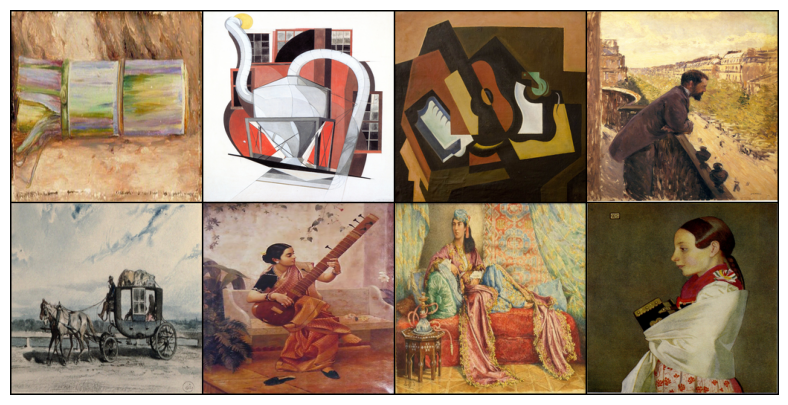

In [15]:
sample_imgs, _ = next(data)
grid_img = torchvision.utils.make_grid(sample_imgs.clamp(-1, 1).add(1).div(2), nrow=4)
plt.figure(figsize=(10, 5))
plt.axis('off')
plt.imshow(grid_img.permute(1, 2, 0));

Accedemos al wandb.login para el seguimiento del modelo entrenado

In [16]:
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [17]:
wandb_run = wandb.init(project=train_cfg.wandb_project,
    entity=train_cfg.wandb_entity,
    name=train_cfg.wandb_name)

wandb: Currently logged in as: vazquezedison (vazquezedison-centro-de-investigaci-n-en-matematicas). Use `wandb login --relogin` to force relogin


dist_util.setup_dist(): Es probable que esta función configure el entorno distribuido para el entrenamiento, como por ejemplo, para configurar la comunicación entre diferentes procesos o nodos si se utiliza computación distribuida (por ejemplo, en varias GPU o máquinas). Esto es esencial para ampliar el entrenamiento a varios dispositivos.

model, diffusion = create_model_and_diffusion(...): create_model_and_diffusion sets up the neural network model (such as U-Net) and the diffusion process based on the provided configuration.

Propósito: Crea e inicializa los componentes de modelo y difusión.
Detalles: La función create_model_and_diffusion toma parámetros de la configuración (convertidos a un diccionario usando args_to_dict) y devuelve dos objetos: model y difusión.
* args_to_dict(train_cfg, model_and_diffusion_defaults().keys()): Esto convierte los ajustes de configuración relevantes en un diccionario y los pasa como argumentos de palabras clave a create_model_and_diffusion.
* model: Representa el modelo de red neuronal (probablemente U-Net o una arquitectura similar).
* difusión: Representa el proceso de difusión o el componente del modelo usado para el entrenamiento.

dist_util.dev() determina el dispositivo (CPU o GPU) para el entrenamiento. El método model.to() transfiere los parámetros y los buffers del modelo al dispositivo especificado, lo que permite un cálculo eficiente en ese dispositivo.

schedule_sampler = create_named_schedule_sampler(train_cfg.schedule_sampler, diffusion):

El muestreo programado en los modelos de difusión se utiliza para gestionar la evolución del proceso de difusión durante el entrenamiento. Implica definir cómo cambian los niveles de ruido y los pasos de tiempo a lo largo del proceso de entrenamiento. En el código, train_cfg.schedule_sampler especifica el tipo de muestreador de programación que se utilizará. Este valor se establece en el diccionario de configuración (cfg), que se pasó a la función create_named_schedule_sampler.

Este parámetro define qué tipo de programa de muestreo se debe utilizar. Los tipos más comunes pueden incluir:
* Uniforme: donde los niveles de ruido se muestrean de manera uniforme a lo largo de los pasos de difusión.
* Lineal: donde los niveles de ruido aumentan o disminuyen linealmente.
* Coseno: donde los niveles de ruido siguen una función coseno.
* Personalizado: cualquier otro programa definido por el usuario.



In [18]:
dist_util.setup_dist()

model, diffusion = create_model_and_diffusion(
    **args_to_dict(train_cfg, model_and_diffusion_defaults().keys()))
model.to(dist_util.dev())

schedule_sampler = create_named_schedule_sampler(
    train_cfg.schedule_sampler, diffusion)

### Loggin y entrenamiento del modelo pre-entrenado

In [19]:
logger.configure(dir=train_cfg.log_dir,
                    wandb_run=wandb_run)

try:
    TrainLoop(
    model=model,
    diffusion=diffusion,
    data=data,
    batch_size=train_cfg.batch_size,
    microbatch=train_cfg.microbatch,
    lr=train_cfg.lr,
    ema_rate=train_cfg.ema_rate,
    log_interval=train_cfg.log_interval,
    save_interval=train_cfg.save_interval,
    resume_checkpoint=train_cfg.resume_checkpoint,
    use_fp16=train_cfg.use_fp16,
    fp16_scale_growth=train_cfg.fp16_scale_growth,
    schedule_sampler=schedule_sampler,
    weight_decay=train_cfg.weight_decay,
    lr_anneal_steps=train_cfg.lr_anneal_steps,
    wandb_run=wandb_run
).run_loop()
    
except KeyboardInterrupt:
    wandb.finish()

Logging to outputs
loading model from checkpoint: /kaggle/working/clip-diffusion-art/pretrained_models/lsun_uncond_100M_1200K_bs128.pt...


/kaggle/working/clip-diffusion-art/./guided-diffusion/guided_diffusion/dist_util.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return th.load(io.BytesIO(data), **kwar

Logging to /tmp/openai-2024-09-18-22-44-29-229146
----------------------
| loss    | 0.00892  |
| loss_q0 | 0.054    |
| loss_q1 | 0.00766  |
| loss_q2 | 0.000639 |
| loss_q3 | 6.32e-05 |
| mse     | 0.00881  |
| mse_q0  | 0.0533   |
| mse_q1  | 0.00761  |
| mse_q2  | 0.000632 |
| mse_q3  | 6.24e-05 |
| samples | 8        |
| step    | 0        |
| vb      | 0.000104 |
| vb_q0   | 0.000705 |
| vb_q1   | 5.53e-05 |
| vb_q2   | 6.39e-06 |
| vb_q3   | 7.33e-07 |
----------------------
saving model 0...
saving model 0.9999...
Found NaN, decreased lg_loss_scale to 19.002000000000002
Found NaN, decreased lg_loss_scale to 18.003000000000004
----------------------
| loss    | 0.0399   |
| loss_q0 | 0.163    |
| loss_q1 | 0.0102   |
| loss_q2 | 0.00192  |
| loss_q3 | 7.62e-05 |
| mse     | 0.0363   |
| mse_q0  | 0.147    |
| mse_q1  | 0.0101   |
| mse_q2  | 0.0019   |
| mse_q3  | 7.52e-05 |
| samples | 88       |
| step    | 10       |
| vb      | 0.00363  |
| vb_q0   | 0.016    |
| vb_q1   | 7

loss,▁▃▇▂▁▄▄▂▃▂▁▁▇▂▂▃▂▂▂▃▂▂▂▄▂▇▄▂▁▂▁▂█▄▂▂▂▃▁▂
loss_q0,▁▃▇▂▁▃▃▂▃▂▂▁▆▂▁▃▂▁▃▂▂▂▂▃▁▅▃▂▁▁▂▂█▃▁▂▂▃▁▂
loss_q1,▃▃▃▄▃▅▄▃▄▃▅▃█▁▃▆▄▃▄▅▅▄▄▂▇▅▃▂▄▄▁▄▄▂▃▆▅▂▆▅
loss_q2,▁▆▅▂▃▃▆▆▅▄▄▄▃▄▅▄▅▃▆▄▃█▅▃▄▄▄▅▆▅▄▃▄▅▄▄▄▇▄▄
loss_q3,▁█▁▆▂▆▄▅▃▃▄▃▃▅▂▅▃▃▂▂▃▄▄▂▃█▅▃▅▇▄▇▃▃▆▃▆▃▂▆
mse,▁▅▅▃▁█▇▄▅▄▂▁▆▄▃▆▄▃▄▅▃▄▄▇▃▅█▃▂▃▂▄█▇▃▄▃▅▂▃
mse_q0,▂▆▄▃▁▇▆▄▅▃▂▁▅▃▂▅▃▂▅▄▂▃▃▅▂▄▆▃▁▂▂▃█▅▂▃▂▄▂▂
mse_q1,▃▃▃▄▃▅▄▃▄▃▅▃█▁▃▆▄▃▄▅▅▄▄▂▇▅▃▂▄▄▁▄▄▂▃▆▅▂▆▅
mse_q2,▁▆▅▂▃▃▆▆▅▄▄▄▃▄▅▄▅▃▆▄▃█▅▃▄▄▄▅▆▅▄▃▄▅▄▄▄▇▄▄
mse_q3,▁█▁▆▂▆▄▅▃▃▄▃▃▅▂▅▃▃▂▂▃▄▄▂▃█▅▃▅▇▄▇▃▃▆▃▆▃▂▆
samples,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


### Descargamos el modelo CLIP para que nos ayude en el seguimiento del prompt y la imagen

CLIP está entrenado previamente en un conjunto masivo de datos de pares de imágenes y texto extraídos de Internet. Aprende a predecir qué texto corresponde a qué imagen, lo que lo hace muy eficaz para tareas en las que se requiere comprender ambas modalidades.

Capacidades de CLIP:

* Aprendizaje de zero-shot: CLIP puede realizar la clasificación de imágenes sin necesidad de un entrenamiento explícito en un conjunto de datos específico. Por ejemplo, puede proporcionar a CLIP un conjunto de etiquetas de clase (como texto) y clasificará las imágenes comparándolas con estas etiquetas.

* Recuperación de texto-imagen: CLIP se puede utilizar para recuperar imágenes en función de consultas de texto o para encontrar descripciones textuales basadas en imágenes.
En resumen, CLIP es un modelo entrenado previamente con una arquitectura dual: un codificador de texto basado en Transformer y un codificador de imágenes basado en ViT o ResNet. Fue diseñado para conectar tareas de lenguaje y visión de manera eficiente en un espacio de representación compartido.

In [27]:
!wget https://api.wandb.ai/files/sreevishnu-damodaran/clip_diffusion_art/29bag3br/256x256_clip_diffusion_art.pt -q

In [26]:
!cd https://api.wandb.ai/files/sreevishnu-damodaran/clip_diffusion_art/29bag3br/

/bin/bash: line 1: cd: https://api.wandb.ai/files/sreevishnu-damodaran/clip_diffusion_art/29bag3br/: No such file or directory


Configuramos los valores para el proceso de generación de imagenes
1. skip_timesteps:
Definición: La cantidad de pasos de tiempo iniciales en el proceso de difusión que se omiten.
Propósito: Omitir los pasos iniciales puede hacer que el proceso sea más rápido y potencialmente más eficiente al saltar directamente a un punto posterior en el proceso de difusión. Esto puede reducir el tiempo de cálculo a costa de algunos detalles finos en la imagen generada.
2. sampling:
Definición: Especifica el método de muestreo que se utilizará para el proceso de difusión.
Ejemplo: "ddim50" se refiere al uso de DDIM (modelos implícitos de difusión de eliminación de ruido) con 50 pasos.
Propósito: Esto controla cómo se reduce el ruido en la imagen. DDIM se utiliza a menudo para hacer que el proceso de difusión sea más rápido y más eficiente en comparación con los métodos de difusión estándar.
3. diffusion_steps:
Definición: La cantidad total de pasos en el proceso de difusión.
Propósito: Esto define cuántas iteraciones se aplican para transformar gradualmente el ruido en una imagen significativa. Más pasos a menudo producen mejores resultados, pero toman más tiempo.
4. clip_guidance_scale:
Definición: Un factor de escala que determina con qué fuerza el modelo CLIP debe guiar la generación de la imagen.
Propósito: Los valores más altos aumentan la influencia del modelo CLIP en la imagen generada, lo que hace que la imagen se adhiera más a la indicación de texto u otra guía proporcionada por CLIP. Los valores más bajos dan más libertad al proceso de difusión para generar imágenes con una guía menos explícita.
5. cutn:
Definición: La cantidad de cortes o segmentos utilizados en el procesamiento de la imagen.
Propósito: Esto probablemente se refiere a la cantidad de recortes de imagen o subimágenes analizadas durante cada iteración. Estos cortes permiten que el modelo analice varias partes de la imagen a la vez, lo que mejora la diversidad y la calidad de la imagen al comparar más características con la indicación CLIP.
6. cutn_batches:
Definición: La cantidad de lotes utilizados para procesar los cortes.
Propósito: Al procesar muchos cortes, el procesamiento por lotes permite que el modelo maneje una gran cantidad de segmentos sin encontrarse con restricciones de memoria. Controla la cantidad de cortes que se procesan a la vez.
7. scale_multiplier:
Definición: Un factor multiplicativo aplicado a varios parámetros de escala en el modelo.
Propósito: Este parámetro ajusta la magnitud de ciertos valores (como clip_guidance_scale o tv_scale), aumentándolos o reduciéndolos según el multiplicador. Ayuda a ajustar el equilibrio de las diferentes fuerzas que guían la generación de la imagen.
8. tv_scale:
Definición: Un factor para la regularización de la variación total.
Propósito: La regularización de la variación total ayuda a reducir el ruido y suavizar la imagen. Un valor tv_scale más alto pone más énfasis en reducir los artefactos visuales y hacer que la imagen sea menos ruidosa y más atractiva visualmente.
9. range_scale:
Definición: Un factor de escala aplicado a la pérdida de rango.
Propósito: Esto generalmente ayuda a mantener los valores de los píxeles dentro de un rango determinado (por ejemplo, entre 0 y 1). Un valor más alto pone más énfasis en restringir la imagen dentro de rangos de píxeles aceptables, lo que reduce la probabilidad de variaciones extremas de color o brillo.
10. loss_fn:
Definición: La función de pérdida utilizada durante el entrenamiento.
Ejemplo: "spherical" se refiere a la pérdida esférica, que minimiza la distancia del coseno entre los vectores de características. Esto se utiliza comúnmente con los modelos de difusión guiados por CLIP para alinear las imágenes generadas con sus indicaciones de texto.
Propósito: La función de pérdida define cómo el modelo mide el error entre la imagen generada y la salida ideal (según lo indicado por CLIP). La elección de la función de pérdida afecta la forma en que el modelo aprende y refina su salida.
11. clip_model:
Definición: La variante del modelo CLIP utilizada para guiar la generación de imágenes.
Ejemplo: "ViT-B/16" se refiere a la variante del modelo Vision Transformer, que utiliza un modelo base (B) con parches de 16x16 píxeles para tareas de visión.
Propósito: El modelo CLIP específico determina cómo se representan y alinean las imágenes y el texto durante el proceso. Los diferentes modelos CLIP varían en tamaño, complejidad y rendimiento.
12. large_sr:
Definición: Indicador booleano que indica si se debe utilizar una superresolución a gran escala.
Propósito: Si es Verdadero, permite la aplicación de técnicas de superresolución para ampliar la imagen final a una resolución más alta, mejorando su claridad y detalle.

In [56]:
cfg_dict = {
    "seed": 84,
    "wandb_project": "clip_diffusion_art",
    "wandb_name": "job7",
    "model_config": "/kaggle/working/clip-diffusion-art/clip_diffusion_art/configs/256x256_clip_diffusion_art.yaml",
    "checkpoint": "/kaggle/working/256x256_clip_diffusion_art.pt",
    "batch_size": 1,
    "skip_timesteps": 5,
    "sampling": "ddim50",
    "diffusion_steps": 1000,
    "clip_guidance_scale": 5000,
    "cutn": 60,
    "cutn_batches": 4,
    "scale_multiplier": 1,
    "tv_scale":75,
    "range_scale": 200,
    "loss_fn":"spherical",
    "clip_model": "ViT-B/16",
    "large_sr": True,
}

cfg_dict["output_dir"] = f"/kaggle/working/{cfg_dict['wandb_name']}"

cfg = SimpleNamespace(**cfg_dict)

In [47]:
!ls /kaggle/working/clip-diffusion-art/clip_diffusion_art/configs

256x256_clip_diffusion_art.yaml  256x256_diffusion_uncond.yaml


In [55]:
!ls /kaggle/working/256x256_clip_diffusion_art.pt

256x256_clip_diffusion_art.pt	 artworks-in-public-domain	outputs
256x256_clip_diffusion_art.pt.1  artworks-in-public-domain.zip	wandb
256x256_clip_diffusion_art.pt.2  clip-diffusion-art


In [28]:
cfg.model_config

'clip_diffusion_art/configs/256x256_clip_diffusion_art.yaml'

In [57]:
seed_all(cfg.seed)

config_file = open(cfg.model_config)
model_config = yaml.load(config_file,
                         Loader=yaml.FullLoader)["model_config"]
print("model_config", model_config)

model_config {'attention_resolutions': '16', 'class_cond': False, 'rescale_timesteps': True, 'rescale_learned_sigmas': True, 'image_size': 256, 'learn_sigma': True, 'noise_schedule': 'linear', 'num_channels': 128, 'num_heads': 1, 'num_res_blocks': 2, 'use_checkpoint': False, 'use_fp16': 'True,', 'use_scale_shift_norm': False}


In [58]:
clip_diffusion = ClipDiffusion(cfg.checkpoint,
    model_config=model_config,
    sampling=cfg.sampling,
    diffusion_steps=cfg.diffusion_steps,
    clip_model=cfg.clip_model,
    device=device
)

100%|███████████████████████████████████████| 335M/335M [00:04<00:00, 85.8MiB/s]


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 206MB/s]  


Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


/opt/conda/lib/python3.10/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_location='cpu'), st

In [59]:
os.makedirs(os.path.join(cfg.output_dir, 'wandb'), exist_ok=True)

wandb_run = wandb.init(project=cfg.wandb_project,
                        dir=cfg.output_dir,
                        name=cfg.wandb_name)

In [61]:
prompts =  ["A border collie playing in a train station"]
num_samples = 4

out_generator = clip_diffusion.sample(
                    prompts,
#                     args.images,
                    num_samples=num_samples,
                    batch_size=cfg.batch_size,
                    skip_timesteps=cfg.skip_timesteps,
#                     clip_denoised=cfg.clip_denoised,
#                     randomize_class=cfg.randomize_class,
#                     eta=cfg.eta,
#                     skip_augs=cfg.skip_augs,
                    cutn=cfg.cutn,
                    cutn_batches=cfg.cutn_batches,
#                     init_image=cf.init_image,
                    loss_fn=cfg.loss_fn,
                    clip_guidance_scale=cfg.clip_guidance_scale,
                    tv_scale=cfg.tv_scale,
                    range_scale=cfg.range_scale,
#                     saturation_scale=cfg.saturation_scale,
#                     init_scale=cfg.init_scale,
                    scale_multiplier=cfg.scale_multiplier,
                    output_dir=cfg.output_dir,
                    wandb_run=wandb_run
                )

0step [00:00, ?step/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Sample 0 : : 44step [01:58,  2.62s/step, output=0, step=43]

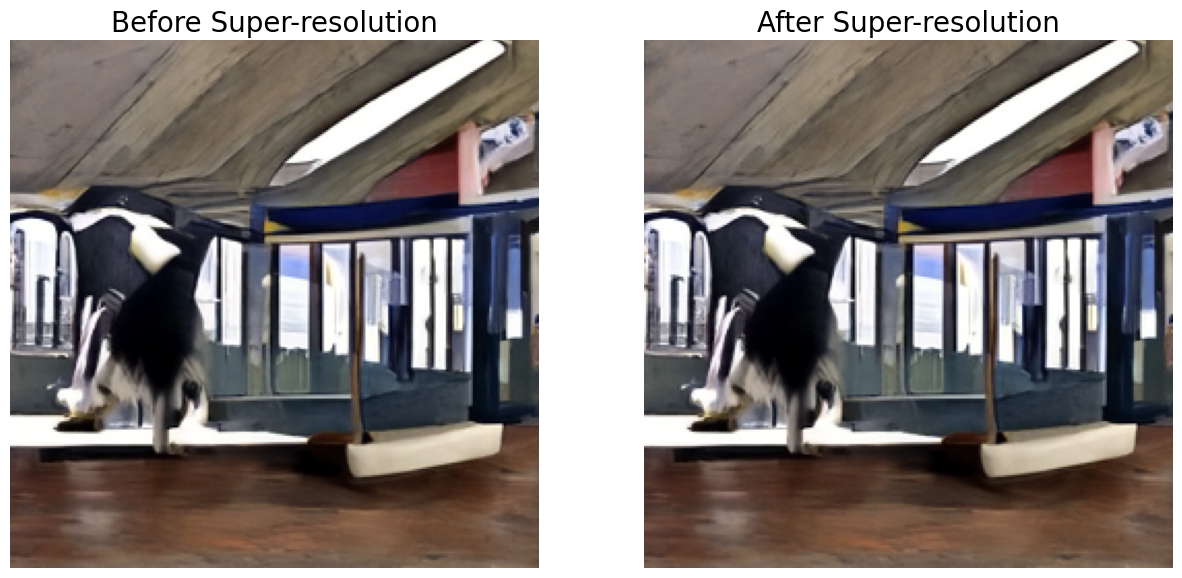

Sample 0 : : 45step [01:59,  2.66s/step, output=0, step=44]
0step [00:00, ?step/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Sample 1 : : 44step [01:56,  2.59s/step, output=0, step=43]

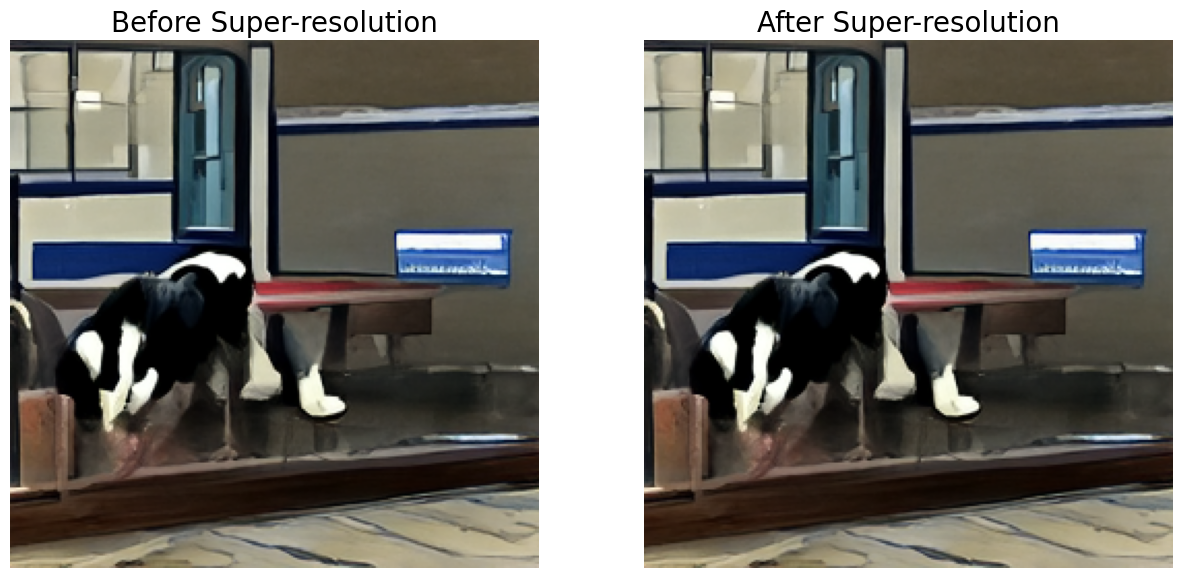

Sample 1 : : 45step [01:57,  2.62s/step, output=0, step=44]
0step [00:00, ?step/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Sample 2 : : 44step [01:56,  2.60s/step, output=0, step=43]

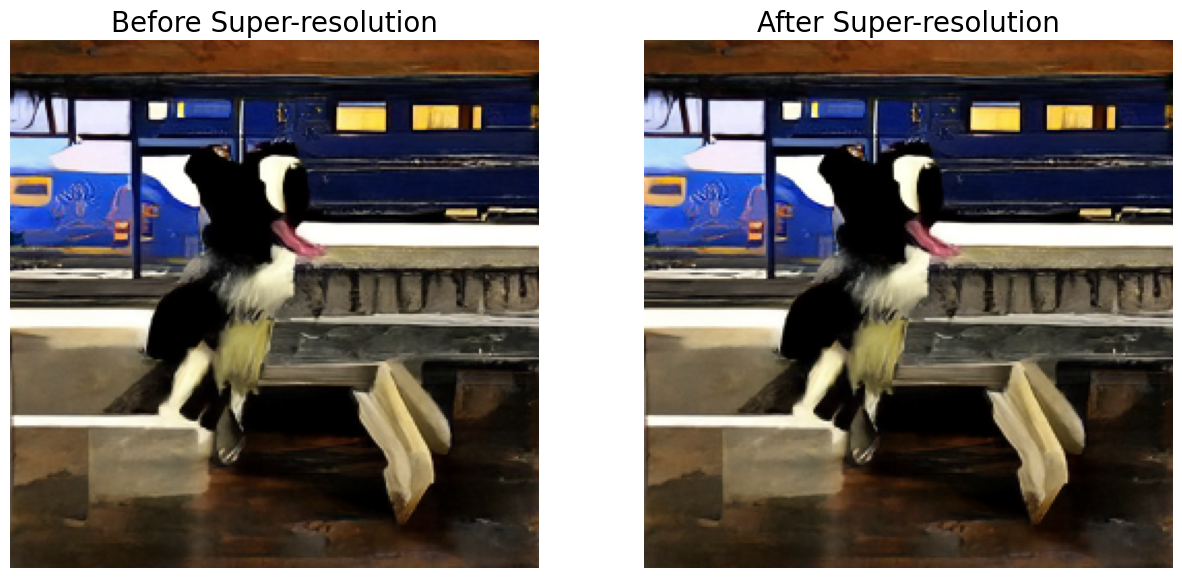

Sample 2 : : 45step [01:57,  2.62s/step, output=0, step=44]
0step [00:00, ?step/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Sample 3 : : 44step [01:57,  2.61s/step, output=0, step=43]

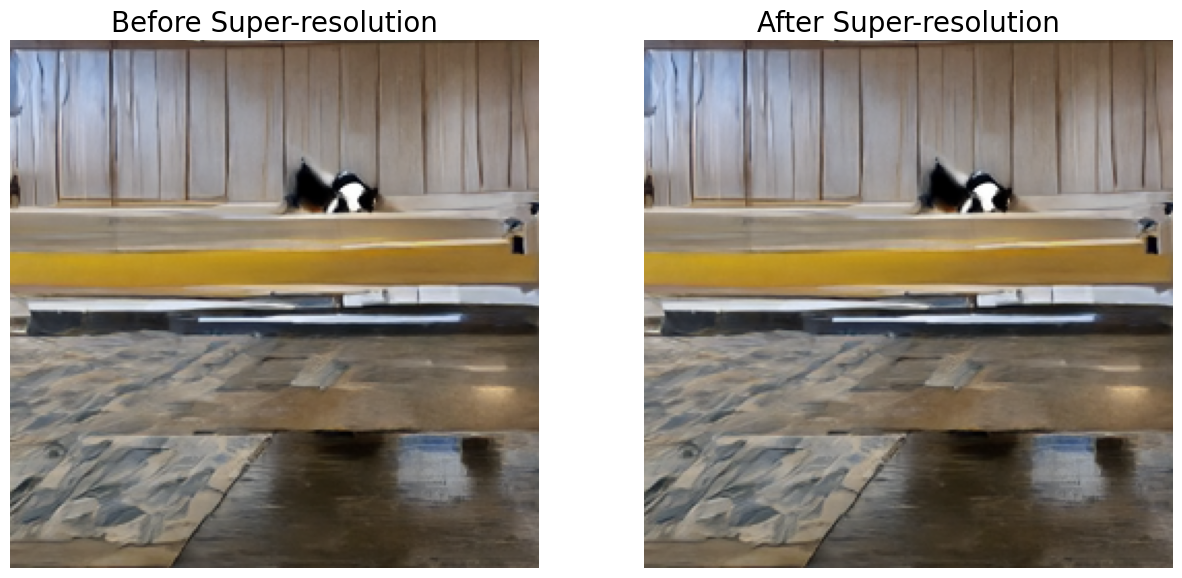

Sample 3 : : 45step [01:58,  2.62s/step, output=0, step=44]


In [62]:
os.makedirs(cfg.output_dir, exist_ok=True)
for i, out_image in enumerate(out_generator):
    disp_image = TF.to_pil_image(out_image.squeeze(0))
    #out_image = clip_diffusion.upscale(out_image,
    #                                    large_sr=cfg.large_sr)
    out_image = TF.to_pil_image(out_image.squeeze(0))
    
    fig, axs = plt.subplots(1, 2, figsize=(15, 18))
    [axi.set_axis_off() for axi in axs.ravel()]
    axs[0].imshow(disp_image)
    axs[0].set_title("Before Super-resolution", fontsize=20)
    axs[1].imshow(out_image)
    axs[1].set_title("After Super-resolution", fontsize=20)
    plt.show()
    
    current_time = datetime.now().strftime('%y%m%d-%H%M%S_%f')
    filename = f'image{i}_{current_time}.png'
    out_image.save(os.path.join(cfg.output_dir, filename))
    
    if wandb_run is not None:
        wandb.log({os.path.splitext(filename)[0]: wandb.Image(os.path.join(cfg.output_dir, filename))})

In [ ]:
if wandb_run is not None:
    for k in range(cfg.batch_size):
        for i in range(num_samples):
            img_files = glob.glob(os.path.join(cfg.output_dir,
                                        f"sample{i}_output{k}_steps", '*'))
            wandb.log(
                {f"sample{i}_output{k}": [wandb.Image(img_path) for img_path
                in sorted(img_files,
                          key=lambda x: int(os.path.splitext(x)[0].split("_")[-1].lstrip("step")))]}
            )
                      
wandb.finish()
